In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

zsh:1: command not found: wget


In [5]:
words = open('names.txt').read().splitlines()

In [6]:
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [33]:
gram_size = 3
neuron_count = 100
batch_size = 32
iterations = 200000
learning_rate = 1

In [13]:
def stoi(c):
  if c == '.':
    return 0
  return ord(c) - ord('a') + 1

def itos(n):
  if n == 0 :
    return '.'
  return chr(n-1+ord('a'))

In [15]:
xs = []
ys = []

In [17]:
for word in words:
  context = '.' * gram_size + word + '.'
  for i in range(len(context)-gram_size):
    x = context[i:i+gram_size]
    y = context[i+gram_size]
    xs.append(x)
    ys.append(y)

In [19]:
xs_int = []
ys_int = []

for x,y in zip(xs, ys):
  xs_int.append([stoi(ch) for ch in x])
  ys_int.append(stoi(y))

In [21]:
x_tensor = torch.tensor(xs_int)
y_tensor = torch.tensor(ys_int)
print(x_tensor.shape)

torch.Size([228146, 3])


In [35]:
g = torch.Generator().manual_seed(2147483647)
embedding_table = torch.randn((27,2), dtype=torch.float32, generator=g, requires_grad=True)
W1 = torch.randn((gram_size*2, neuron_count), dtype=torch.float32, generator=g, requires_grad=True)
b1 = torch.randn((neuron_count), dtype=torch.float32, generator=g, requires_grad=True)
W2 = torch.randn((neuron_count, 27), dtype=torch.float32, generator=g, requires_grad=True)
b2 = torch.randn((27), dtype=torch.float32, generator=g, requires_grad=True)
parameters = [embedding_table, W1, b1, W2, b2]

In [37]:
sum(p.nelement() for p in parameters)

3481

In [39]:
for i in range(iterations):

  #minibatch
  ix = torch.randint(0, x_tensor.shape[0], (batch_size,))

  # Forward pass
  x_enc = embedding_table[x_tensor[ix]].view(-1, W1.shape[0])
  h = torch.tanh(x_enc @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y_tensor[ix])

  if i % 50000 == 0:
    learning_rate *= 0.1
    print(loss.item())

  # Set gradient to zero
  for p in parameters:
    p.grad = None

  # Backward pass
  loss.backward()

  # Update parameters
  for p in parameters:
    p.data += -learning_rate * p.grad

print(loss)

19.99759864807129
2.5833096504211426
2.205961227416992


KeyboardInterrupt: 

In [78]:
for i in range(20):
  context = [0] * gram_size
  out=[]
  while True:
    context_tensor = torch.tensor([context])
    context_enc = embedding_table[context_tensor].view(-1, W1.shape[0])
    h_pred = torch.tanh(context_enc @ W1 + b1)
    logits_pred = h_pred @ W2 + b2
    p = F.softmax(logits_pred, dim=1)
    next_index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if next_index == 0:
      break
    out.append(itos(next_index))
    context = context[1:] + [next_index]
  print(''.join(out))

muca
kynnzle
jeyloryn
marsen
sii
kahnatarnet
akria
ramya
jamedhn
kasemarlonammanka
kafeyger
mira
jashaythey
jar
arm
cale
kaxelsaa
rhaafayeena
sakumarch
kanttym


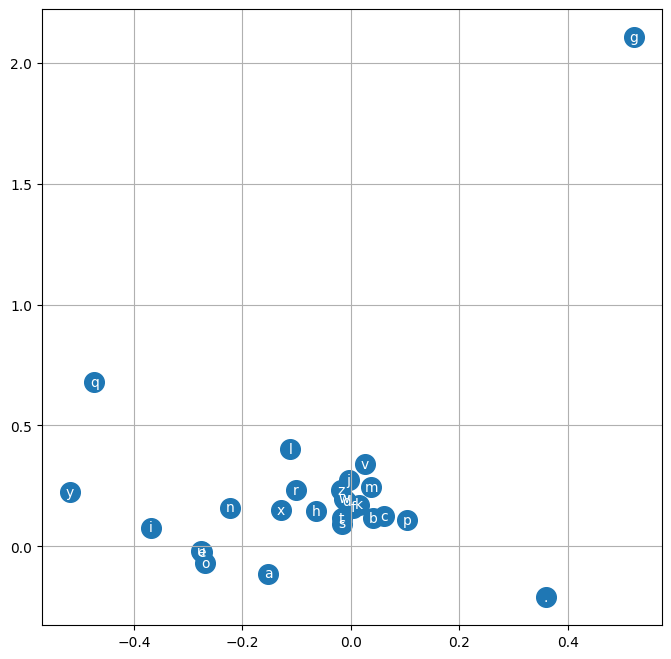

In [49]:
C = embedding_table
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos(i), ha="center", va="center", color='white')
plt.grid('minor')

Using cross entropy is better because it is faster and prevent nan for exp operations otherwise. See: https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3
